In [2]:
from matplotlib import colors, cm
import matplotlib.pyplot as plt
import scipy.io
import itertools
from skimage import io, filters, morphology, restoration, feature, transform
from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from itertools import cycle
import sklearn.cluster
from sklearn.preprocessing import MinMaxScaler
import skimage.segmentation as seg

import numpy as np

import nglpy_cuda as ngl
import topopy
import pdir
import time
import os
import utpy.utils
import utpy.vis
import flatpy

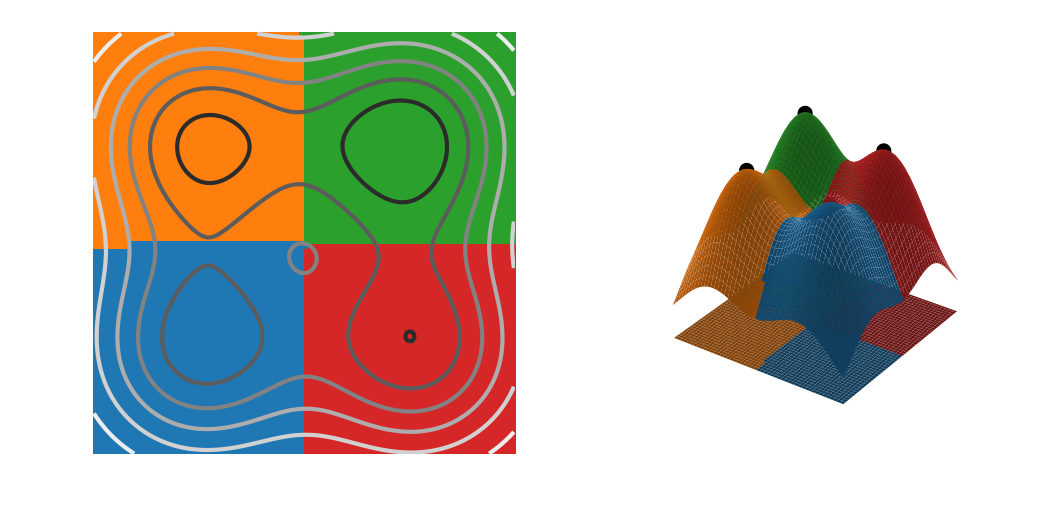

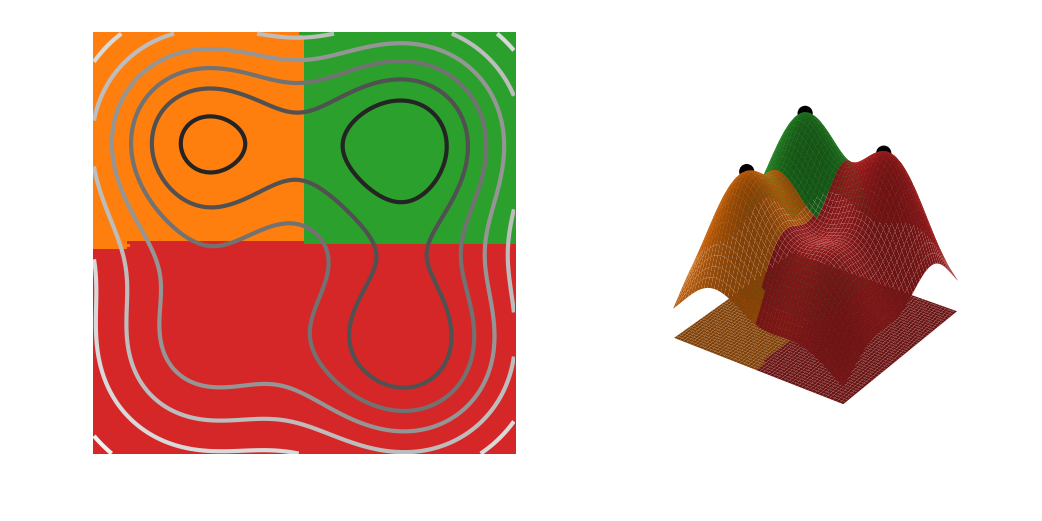

In [3]:
%matplotlib inline

sigma = 0.075
max_x_1 = 0.25
max_y_1 = 0.25
max_x_2 = 0.25
max_y_2 = 0.75
def four_bumps(_x):
    x, y = flatpy.utils.unpack_2d(_x)
    eps = 0.01*y + 0.01*x
    return (0.5 * np.exp(-(((x-max_x_1)**2)/sigma +((y-max_y_1)**2)/sigma)) +
            0.54 * np.exp(-(((x-0.75)**2)/sigma +((y-0.25)**2)/sigma)) +
            0.51 * np.exp(-(((x-max_x_2)**2)/sigma +((y-0.77)**2)/sigma)) +
            0.58 * np.exp(-(((x-0.75)**2)/sigma +((y-0.75)**2)/sigma)) + eps
           )

def three_bumps(_x, t=0.4):
    x, y = flatpy.utils.unpack_2d(_x)
    eps = 0.01*y + 0.01*x
    amplitude = (1-t)*0.54
    x_loc = (1-t)*max_x_1 + t*max_x_2
    return (amplitude * np.exp(-(((x-x_loc)**2)/sigma +((y-max_y_1)**2)/sigma)) +
            0.54 * np.exp(-(((x-0.75)**2)/sigma +((y-0.25)**2)/sigma)) +
            0.51 * np.exp(-(((x-max_x_2)**2)/sigma +((y-max_y_2)**2)/sigma)) +
            0.58 * np.exp(-(((x-0.75)**2)/sigma +((y-0.75)**2)/sigma)) + eps
           )

resolution=150
X = flatpy.utils.generate_test_grid_2d(resolution)
f1 = four_bumps(X)
f2 = three_bumps(X)

x, y = np.mgrid[0:1:(resolution *1j), 0:1:(resolution*1j)]
f1 = f1.reshape(resolution,resolution)
f2 = f2.reshape(resolution,resolution)

graph = ngl.EmptyRegionGraph(**utpy.utils.graph_params)
tmc = topopy.MorseComplex(graph=graph, normalization=None)
tmc.build(X, f1.flatten())

n_clusters = 4
for p in tmc.persistences:
    if len(tmc.get_partitions(p).keys()) <= n_clusters:
        partitions = tmc.get_partitions(p)
        break

keys = list(partitions.keys())
keyMap = {}
for i, k in enumerate(keys):
    keyMap[k] = i

ccycle = cycle(plt.cm.tab10.colors)
uniqueCount = len(keys)
usedColors = []
for i, c in zip(range(uniqueCount), ccycle):
    usedColors.append(c)
cmap = colors.ListedColormap(usedColors)

for f in [f1, f2]:
    for p in tmc.persistences:
        if len(tmc.get_partitions(p).keys()) <= n_clusters:
            partitions = tmc.get_partitions(p)
            break

    color_mesh = np.zeros((resolution, resolution), dtype=int)
    for key, indices in partitions.items():
        for idx in indices:
            color_mesh[idx // resolution, idx % resolution] = keyMap[key]
    
    keys = list(partitions.keys())
    fig = plt.figure(dpi=200)
    ax = fig.add_subplot(1, 2, 1)
    plt.imshow(plt.cm.tab10(color_mesh.T))
    ax.set_ylim(0,resolution)
#     ax.set_xlim(resolution,0)
    ax.axis("off")
    plt.contour(f,cmap=plt.cm.Greys)
    ax = fig.add_subplot(1, 2, 2, projection="3d")
    surf = ax.plot_surface(x, y, f, linewidth=0, antialiased=True, facecolors=plt.cm.tab10(color_mesh))
    surf = ax.plot_surface(x, y, np.zeros(x.shape), linewidth=0, antialiased=True, facecolors=plt.cm.tab10(color_mesh))
    ax.scatter(X[keys, 0], X[keys, 1], f.flatten()[keys], s=20, alpha=1, c="#000000",zorder=5)
    # ax.contour(x, y, f, cmap=plt.cm.Greys, linewidths=3, alpha=1)
    ax.view_init(azim=215)
    ax.set_aspect(1)
    ax.axis("off")
    n_clusters -= 1